In [5]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import time

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline

print("Imports imported")

Imports imported


In [6]:
car_basedir = 'vehicles/' 

image_types = os.listdir(car_basedir)

cars = []

for imtype in image_types:
    cars.extend(glob.glob(car_basedir+imtype+'/*'))
    
with open("cars.txt", "w") as f:
    for fn in cars:
        f.write(fn+'\n')

print('Number of vehicles : ', len(cars))


('Number of vehicles : ', 8792)


In [7]:
noncar_basedir = 'non-vehicles/' 

image_types = os.listdir(noncar_basedir)

notcars = []

for imtype in image_types:
    notcars.extend(glob.glob(noncar_basedir+imtype+'/*'))

print('Number of nonvehicles : ', len(notcars))

with open("notcars.txt", "w") as f:
    for fn in notcars:
        f.write(fn+'\n')

('Number of nonvehicles : ', 8968)


In [15]:
# Functions from lesson

# Define a function to return HOG features and visualization
# Vis == False means we do not want to get an image back, True produces output image.
def get_hog_features(img, 
                     orient, 
                     pix_per_cell, 
                     cell_per_block, 
                     vis=False, 
                     feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, 
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, 
                                  feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, 
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, 
                       feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    # Returns a stacked feature vector of the three color channels
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# Removed bin range because it breaks when png files get read in.
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, 
                     color_space='RGB',
                     spatial_size = (32,32),
                     hist_bins = 32,
                     orient=9, 
                     pix_per_cell=8, 
                     cell_per_block=2, 
                     hog_channel= 0,
                     spatial_feat = True,
                     hist_feat = True,
                     hog_feat = True):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        img = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)      
  
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat == True:
            # Apply color hist()
            hist_features = color_hist(feature_image, nbins = hist_bins)
            file_features.append(hist_features)
        
        if hog_feat == True:
            
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, 
                                        pix_per_cell, 
                                        cell_per_block, 
                                        vis=False, 
                                        feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                orient, 
                                                pix_per_cell, 
                                                cell_per_block, 
                                                vis=False, 
                                                feature_vec=True)
                # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, 
                 x_start_stop=[None, None], 
                 y_start_stop=[None, None], 
                 xy_window=(96, 96), 
                 xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
#     nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
#     ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))   
#     nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
#     ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list

# Here is the draw_boxes function.
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image and a list of templates as inputs
# then searches the image and returns the a list of bounding boxes 
# for matched templates
def find_matches(img, template_list):
    # Make a copy of the image to draw on
    
    # Define an empty list to take bbox coords
    bbox_list = []
    method = cv2.TM_CCOEFF_NORMED
    # Iterate through template list
    for temp in template_list:
        # Read in templates one by one
        tmp = mpimg.imread(temp)
        
        # Use cv2.matchTemplate() to search the image
        # using whichever of the OpenCV search methods you prefer
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
        # Return the list of bounding boxes
        
    return bbox_list

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def single_img_features(img, 
                        color_space='RGB', 
                        spatial_size=(32, 32),
                        hist_bins=32, 
                        orient=9, 
                        pix_per_cell=8,
                        cell_per_block=2, 
                        hog_channel=0, 
                        spatial_feat=True,
                        hist_feat=True, 
                        hog_feat=True,
                        vis=False):
    img_features = []
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
        
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
        
    if hog_feat == True:
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                    orient, 
                                                    pix_per_cell, 
                                                    cell_per_block,
                                                    vis=False, 
                                                    feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel],
                                                    orient, 
                                                    pix_per_cell, 
                                                    cell_per_block,
                                                    vis=True, 
                                                    feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                                orient, 
                                                pix_per_cell, 
                                                cell_per_block,
                                                vis=False, 
                                                feature_vec=True)
        img_features.append(hog_features)
    
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, 
                   windows, 
                   clf, 
                   scaler, 
                   color_space='RGB', 
                   spatial_size=(32, 32), 
                   hist_bins=32, 
                   hist_range=(0, 256), 
                   orient=9, 
                   pix_per_cell=8, 
                   cell_per_block=2, 
                   hog_channel='ALL', 
                   spatial_feat=True, 
                   hist_feat=True, 
                   hog_feat=True):

    # 1) Create an empty list to receive positive detection windows
    # This array will have positive window detections appended to it.
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  
        
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, 
                                       color_space=color_space, 
                                       spatial_size=spatial_size, 
                                       hist_bins=hist_bins, 
                                       orient=orient, 
                                       pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel, 
                                       spatial_feat=spatial_feat, 
                                       hist_feat=hist_feat, 
                                       hog_feat=hog_feat
                                      )
        
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows


def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])   
        else:
            plt.imshow(img)
            plt.title(titles[i])
            
print('Functions loaded')

Functions loaded


Ran


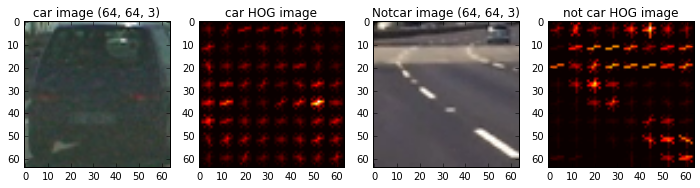

In [16]:
# Choose random images from the images of cars and non cars read in
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in a car and non car image
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_img_features(car_image,
                                                  color_space = color_space,
                                                  spatial_size = spatial_size,
                                                  hist_bins = hist_bins,
                                                  orient = orient,
                                                  pix_per_cell = pix_per_cell,
                                                  cell_per_block = cell_per_block,
                                                  hog_channel = hog_channel,
                                                  spatial_feat = spatial_feat,
                                                  hist_feat = hist_feat,
                                                  hog_feat = hog_feat,
                                                  vis = True
                                                 )

notcar_features, notcar_hog_image = single_img_features(notcar_image,
                                                  color_space = color_space,
                                                  spatial_size = spatial_size,
                                                  hist_bins = hist_bins,
                                                  orient = orient,
                                                  pix_per_cell = pix_per_cell,
                                                  cell_per_block = cell_per_block,
                                                  hog_channel = hog_channel,
                                                  spatial_feat = spatial_feat,
                                                  hist_feat = hist_feat,
                                                  hog_feat = hog_feat,
                                                  vis = True
                                                 )
images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image '+str(car_image.shape)+'', 'car HOG image', 'Notcar image '+str(notcar_image.shape)+'', 'not car HOG image']
fig = plt.figure(figsize=(12,3)) 
visualize(fig, 1, 4, images, titles)
print('Ran')

In [22]:
# Define feature parameters
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()
n_samples = 2000
# Generate 1000 random indices
random_idxs = np.random.randint(0 , len(cars), n_samples)
test_cars = np.array(cars)[random_idxs]
test_notcars = np.array(notcars)[random_idxs]

car_features = extract_features(test_cars,
                               color_space = color_space,
                               spatial_size = spatial_size,
                               hist_bins = hist_bins,
                               orient = orient,
                               pix_per_cell = pix_per_cell,
                               cell_per_block = cell_per_block,
                               hog_channel = hog_channel,
                               spatial_feat = spatial_feat,
                               hist_feat = hist_feat,
                               hog_feat = hog_feat
                               )

notcar_features = extract_features(test_notcars,
                               color_space = color_space,
                               spatial_size = spatial_size,
                               hist_bins = hist_bins,
                               orient = orient,
                               pix_per_cell = pix_per_cell,
                               cell_per_block = cell_per_block,
                               hog_channel = hog_channel,
                               spatial_feat = spatial_feat,
                               hist_feat = hist_feat,
                               hog_feat = hog_feat
                               )

print(time.time()-t, 'Seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X,
                                                   y,
                                                   test_size = 0.1,
                                                   random_state = rand_state
                                                   )
print('Using : ', orient,' orientations, ',pix_per_cell,'pixels per cell ', cell_per_block,'...etc...')
print('Feature vector length : ', len(X_train[0]))

# Use SVC
svc = LinearSVC()

t = time.time()
svc.fit(X_train, y_train)
print(round(time.time() -t, 2 ), "Seconds to train SVC...")

print('Test accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

(24.926110982894897, 'Seconds to compute features...')
('Using : ', 9, ' orientations, ', 8, 'pixels per cell ', 2, '...etc...')
('Feature vector length : ', 6108)
(10.53, 'Seconds to train SVC...')
('Test accuracy of SVC = ', 0.9875)


(0.0, 1.0)
(1.1065990924835205, 'seconds to process one image searching', 273, ' windows')
(0.0, 1.0)
(0.9615588188171387, 'seconds to process one image searching', 273, ' windows')
(0.0, 1.0)
(0.9525389671325684, 'seconds to process one image searching', 273, ' windows')
(0.0, 1.0)
(0.9758510589599609, 'seconds to process one image searching', 273, ' windows')
(0.0, 1.0)
(0.9927761554718018, 'seconds to process one image searching', 273, ' windows')
(0.0, 1.0)
(0.9939589500427246, 'seconds to process one image searching', 273, ' windows')
(0.0, 1.0)
(1.056870937347412, 'seconds to process one image searching', 266, ' windows')


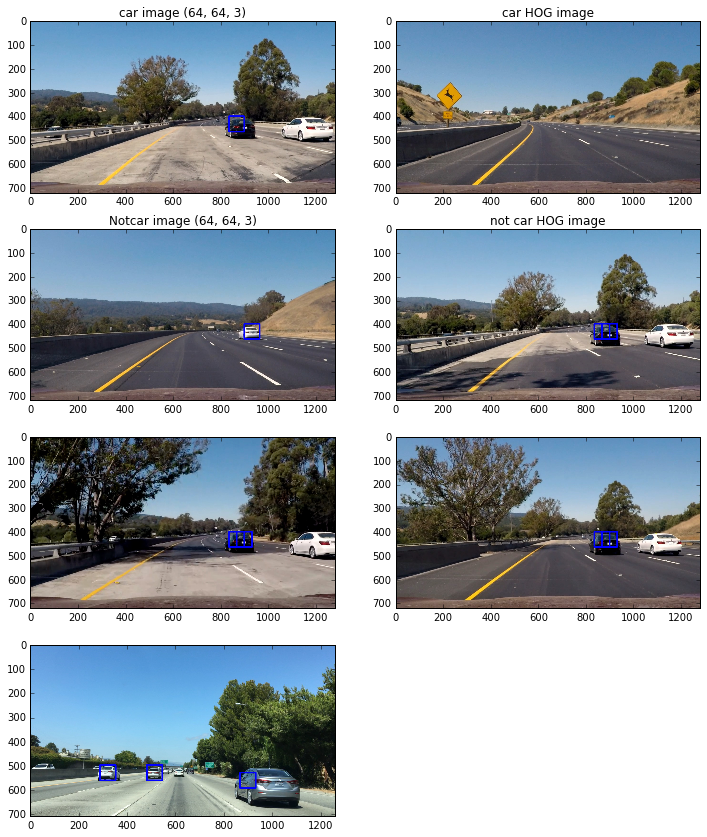

In [23]:
searchpath = 'test_run/*'
example_images = glob.glob(searchpath)
images = []
title = []
y_start_stop = [400, 656]
overlap = 0.5

for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    print(np.min(img), np.max(img))
    
    windows = slide_window(img,
                          x_start_stop= [None, None],
                          y_start_stop = y_start_stop,
                          xy_window = (64, 64),
                          xy_overlap = (overlap, overlap)
                          )
    
    hot_windows = search_windows(img,
                                windows,
                                svc,
                                X_scaler,
                                color_space = color_space,
                                spatial_size = spatial_size,
                                hist_bins = hist_bins,
                                orient = orient,
                                pix_per_cell = pix_per_cell,
                                cell_per_block = cell_per_block,
                                hog_channel = hog_channel,
                                spatial_feat = spatial_feat,
                                hist_feat = hist_feat,
                                hog_feat = hog_feat 
                                )
    
    window_img = draw_boxes(draw_img, hot_windows, color = (0, 0, 255), thick = 6)
    images.append(window_img)
    titles.append('')
    print(time.time() - t1, 'seconds to process one image searching', len(windows),' windows')
    
fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig,5,2,images,titles)
    

In [8]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == "RGB2YCrCb":
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
print('Convert color loaded')

Convert color loaded


(0.4654581546783447, 'seconds to run, total windows = ', 160)
(0.39815378189086914, 'seconds to run, total windows = ', 160)
(0.39394593238830566, 'seconds to run, total windows = ', 160)
(0.4154660701751709, 'seconds to run, total windows = ', 160)
(0.4561491012573242, 'seconds to run, total windows = ', 160)
(0.4325709342956543, 'seconds to run, total windows = ', 160)
(0.4182250499725342, 'seconds to run, total windows = ', 156)


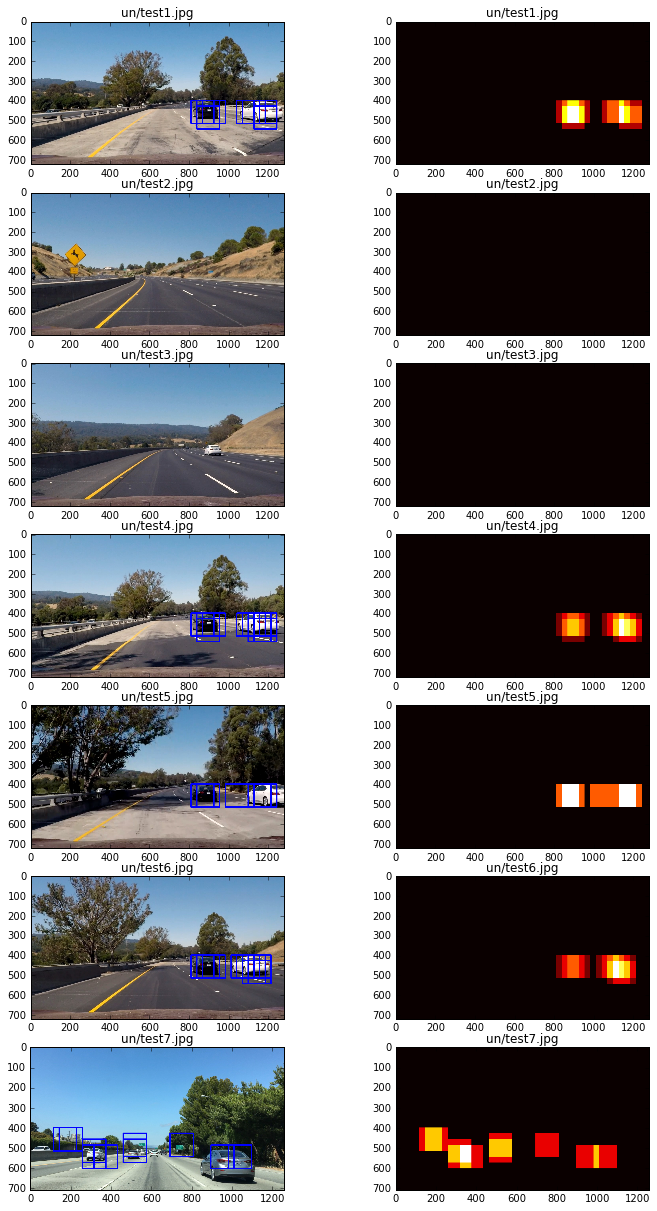

In [9]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []
ystart = 400
ystop = 656
# Scale entire image and subsample the array
scale = 1.8

for img_src in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    
    # Make a heat map
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32) / 255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
   
    # Use // to remove floating points from results
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    
    nfeat_per_block = orient * cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # Extract the image patch   
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
   
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw + ystart),(xbox_left + win_draw, ytop_draw + win_draw + ystart),(0,0,255),6)
                img_boxes.append(((xbox_left, ytop_draw +  ystart),(xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                heatmap[ytop_draw + ystart:ytop_draw + win_draw + ystart, xbox_left:xbox_left + win_draw] +=1
                
    print(time.time() - t, 'seconds to run, total windows = ', count)
    
    out_images.append(draw_img)
    
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
    
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)

fig = plt.figure(figsize = (12,24))
visualize(fig, 8, 2, out_images, out_titles)  
# 

In [10]:
def find_cars(img, scale):
    
    draw_img = np.copy(img)
    
    # Make a heat map
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32) / 255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
   
    # Use // to remove floating points from results
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    
    nfeat_per_block = orient * cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
#             count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # Extract the image patch   
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
   
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw + ystart),(xbox_left + win_draw, ytop_draw + win_draw + ystart),(0,0,255),6)
                img_boxes.append(((xbox_left, ytop_draw +  ystart),(xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                heatmap[ytop_draw + ystart:ytop_draw + win_draw + ystart, xbox_left:xbox_left + win_draw] +=1
                
#     print(time.time() - t, 'seconds to run, total windows = ', count)
    
    out_images.append(draw_img)
    
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
    
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)

    return draw_img, heatmap

In [11]:
def apply_threshold(heatmap, threshold):
    
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return the image after applying threshold
    return

def draw_labeled_bboxes(img, labels):
    
    # Iterate over all detected cars
    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1],(0,0,255), 6)
    return img

print('Functions loaded')

Functions loaded


ValueError: num must be 1 <= num <= 16, not 17

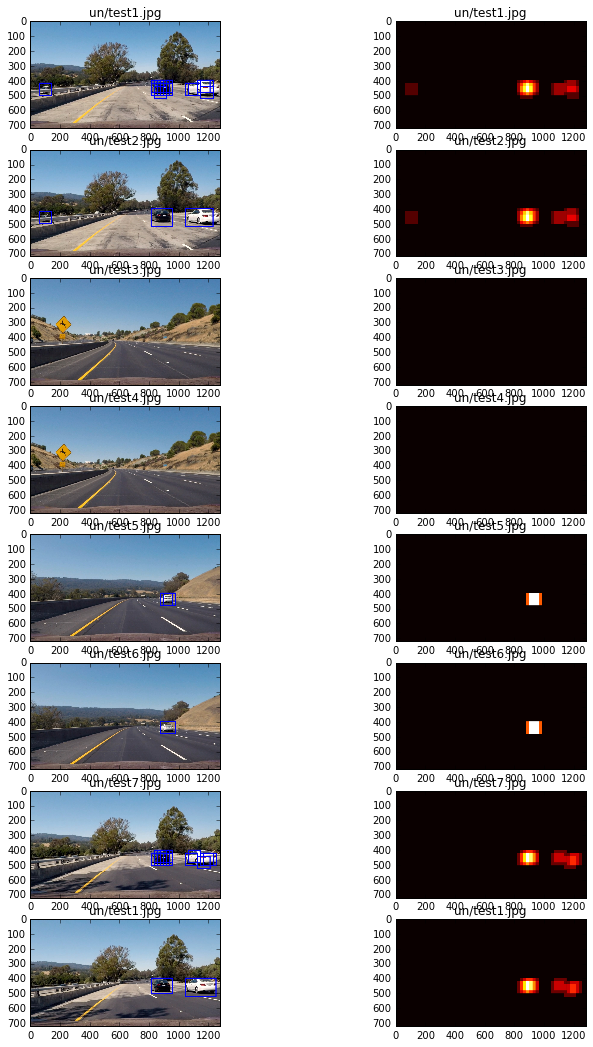

In [16]:
out_images = []
out_maps = []
ystart = 400
ystop = 656
# Scale entire image and subsample the array
scale = 1.3

for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    
fig = plt.figure(figsize=(12,18))
visualize(fig,8,2,out_images,out_titles)

In [17]:
def process_image(img):
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('Process image loaded')

Process image loaded


In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

print('Imports imported')

Imports imported


In [19]:
test_output = 'test.mp4'
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image)

test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████▉| 1260/1261 [12:09<00:00,  2.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 



In [ ]:
class Vehicle():
    def __init__(self):
        self.detected = False
        self.n_detection = 0
        self.n_nondetection = 0
        self.xpixels = None
        self.ypixels = None
        self.recent_xfitted = []
        self.bestx = None
        self.recent_yfitted = []
        self.besty = None
        self.recent_wfitted = []
        self.bestw = None
        self.recent_hfitted = []
        self.besth = None
        
print('Vehicle class loaded')